# Simple regression case using tensorflow probability


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

### True Model & Observed Data

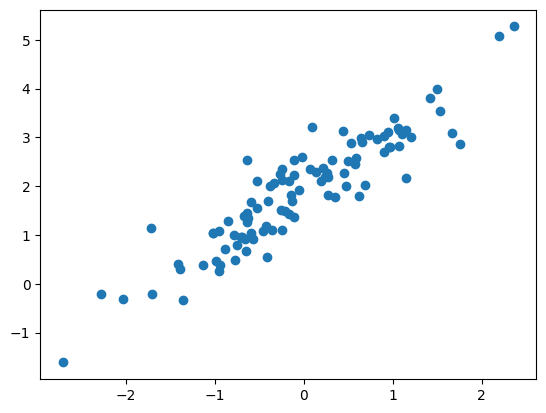

In [7]:
# simulate true model and observed data
N_observations = 100

slope = 1.2
intercept = 1.9
noise_eps = 0.5
x = np.random.normal(0,1, N_observations)#.sample(N_observations)
noise = np.random.normal(0,noise_eps, N_observations)

y = slope*x + intercept + noise

# Convert x and y to TensorFlow tensors
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

plt.scatter(x,y)

# Hierarchical Model


Assume linear relation
$ y = \beta * X + \alpha$


We can also model the noise,

$y \sim Normal(\mu, \epsilon)$

$ \mu = \beta * X + \alpha$

Lets assume all parameters follow normal distributions. Note that $\epsilon$ must be positive


In [21]:
# Target model
model = tfd.JointDistributionSequentialAutoBatched([
    tfd.Normal(loc=0., scale=1., name='m'),   # m
    tfd.Normal(loc=0., scale=1., name='b'),   # b
    tfd.HalfNormal(scale=1., name='eps'),        # eps
    lambda eps, b, m: tfd.Normal(loc=b*x + m, scale=eps) # Y
])

target_log_prob_fn = lambda m, b, eps: model.log_prob([m, b, eps, y])

In [22]:
# Some simple tests

print('Shapes:', [i.shape for i in model.log_prob_parts(model.sample(7))])
print('Parts:\n', model.log_prob_parts(model.sample(7)))
print('LogProb:', model.log_prob(model.sample(3)))

print('-----')
s = model.sample(2)
print(model.log_prob(s))

sum_parts = 0
for i in model.log_prob_parts(s):
    sum_parts += i
print(sum_parts)
print(tf.reduce_sum(model.log_prob_parts(s), axis=0))

print('confirmed same')


Shapes: [TensorShape([7]), TensorShape([7]), TensorShape([7]), TensorShape([7])]
Parts:
 [<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([-0.92717344, -1.9388599 , -0.93588907, -0.9860295 , -3.2509947 ,
       -0.9727016 , -1.1117444 ], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([-1.7589717 , -0.96777713, -1.6296513 , -1.8347015 , -0.9549584 ,
       -2.2387953 , -1.3389351 ], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([-0.226357  , -0.3292357 , -0.22669816, -0.41603863, -0.8954247 ,
       -0.23598626, -0.5078374 ], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([ 201.89862 ,  -54.168114,  184.25127 ,  -79.99445 , -153.39261 ,
         58.2499  , -116.334915], dtype=float32)>]
LogProb: tf.Tensor([-218.60158 -106.92325  -86.29017], shape=(3,), dtype=float32)
-----
tf.Tensor([-138.10379 -194.40149], shape=(2,), dtype=float32)
tf.Tensor([-138.10379 -194.40149], shape=(2,), dtype=float32)
tf.Tensor([-138.10379 

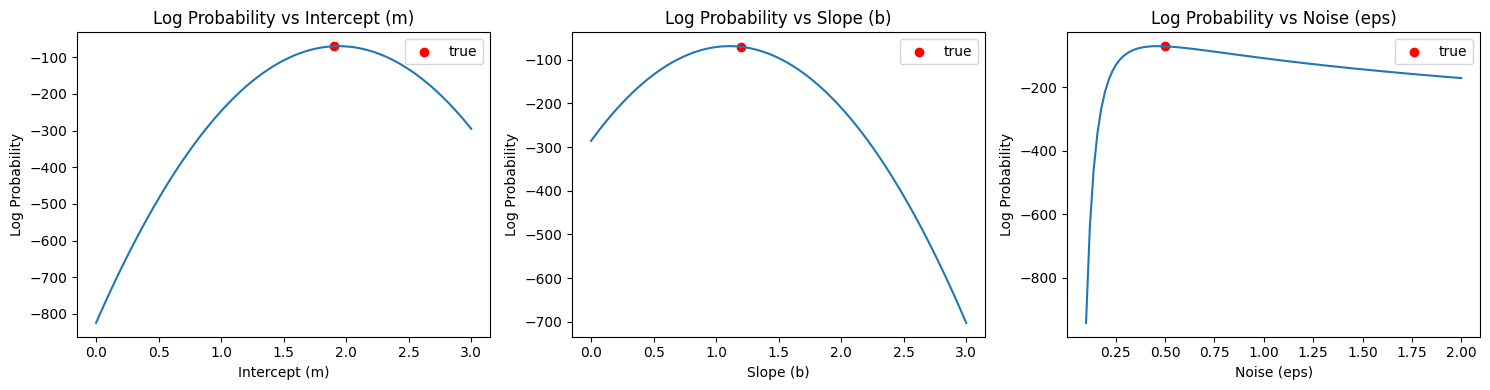

In [25]:
# Test to verify the logprob. create a marginal plot over each parameters logprob given the other params have the true value.

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Intercept (m) plot
m_linspace = np.linspace(0, 3, 100)
logprobs_m = [target_log_prob_fn(m_i, slope, noise_eps) for m_i in m_linspace]

axs[0].plot(m_linspace, logprobs_m)
axs[0].scatter(intercept, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
axs[0].set_xlabel("Intercept (m)")
axs[0].set_ylabel("Log Probability")
axs[0].legend()
axs[0].set_title("Log Probability vs Intercept (m)")

# Slope (b) plot
b_linspace = np.linspace(0, 3, 100)
logprobs_b = [target_log_prob_fn(intercept, b_i, noise_eps) for b_i in b_linspace]

axs[1].plot(b_linspace, logprobs_b)
axs[1].scatter(slope, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
axs[1].set_xlabel("Slope (b)")
axs[1].set_ylabel("Log Probability")
axs[1].legend()
axs[1].set_title("Log Probability vs Slope (b)")

# Noise (eps) plot
eps_linspace = np.linspace(0.1, 2, 100)
logprobs_eps = [target_log_prob_fn(intercept, slope, eps_i) for eps_i in eps_linspace]

axs[2].plot(eps_linspace, logprobs_eps)
axs[2].scatter(noise_eps, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
axs[2].set_xlabel("Noise (eps)")
axs[2].set_ylabel("Log Probability")
axs[2].legend()
axs[2].set_title("Log Probability vs Noise (eps)")

plt.tight_layout()
plt.show()

In [26]:
# Implement HMC
# Initialize the current state with tensors for m, b, and eps
current_state = [tf.zeros([], name="init_m"),
                 tf.zeros([], name="init_b"),
                 tf.ones([], name="init_eps")]

num_results = 1000
num_burnin_steps = 1000
num_leapfrog_steps = 1
step_size = float(0.1)
num_chains = 5

#hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, num_leapfrog_steps=num_leapfrog_steps, step_size=step_size)
hmc = tfp.mcmc.NoUTurnSampler(target_log_prob_fn, step_size=step_size)

# Using no adaptive stepsize constant output equal to initail. Very hard to find the right step size
kernel = tfp.mcmc.SimpleStepSizeAdaptation(hmc, num_adaptation_steps=int(num_burnin_steps * 0.8))

@tf.function
def run_chain():
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=current_state,
        kernel=kernel,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,#pkr.is_accepted, - inner_results when using step size adapt
        num_burnin_steps=num_burnin_steps
    )
    return samples

# Run sampling.
chains = [run_chain() for i in range(num_chains)]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [27]:
for c in chains:
    [mm, bb, ee] = c
    print(mm[-5:], len(np.unique(mm)))
    print(bb[-5:], len(np.unique(bb)))
    print(ee[-5:], len(np.unique(ee)))
    print()

tf.Tensor([1.9641547 1.9460504 1.9381933 1.9625375 1.9090817], shape=(5,), dtype=float32) 831
tf.Tensor([1.134003  1.0804558 1.1373693 1.1665176 1.0336196], shape=(5,), dtype=float32) 831
tf.Tensor([0.44551247 0.46961853 0.45403132 0.47652104 0.47479114], shape=(5,), dtype=float32) 831

tf.Tensor([1.9298718 1.8958964 1.881308  1.9551448 1.9623824], shape=(5,), dtype=float32) 827
tf.Tensor([1.072365  1.1334208 1.0824578 1.0810168 1.2035421], shape=(5,), dtype=float32) 827
tf.Tensor([0.43624258 0.45016792 0.42546093 0.41690785 0.41878253], shape=(5,), dtype=float32) 827

tf.Tensor([1.9644401 1.9537575 1.9016557 1.9771394 1.9771394], shape=(5,), dtype=float32) 797
tf.Tensor([1.1750672 1.0777701 1.0992554 1.1268456 1.1268456], shape=(5,), dtype=float32) 797
tf.Tensor([0.5842884  0.48280004 0.43045735 0.43461156 0.43461156], shape=(5,), dtype=float32) 797

tf.Tensor([1.8747926 2.0164568 1.8865486 1.9529451 1.9591104], shape=(5,), dtype=float32) 790
tf.Tensor([1.0432702  0.99267435 1.225819 

m: mean=1.938, 95% CI=(1.845, 2.027)
b: mean=1.108, 95% CI=(1.009, 1.205)
eps: mean=0.464, 95% CI=(0.403, 0.534)


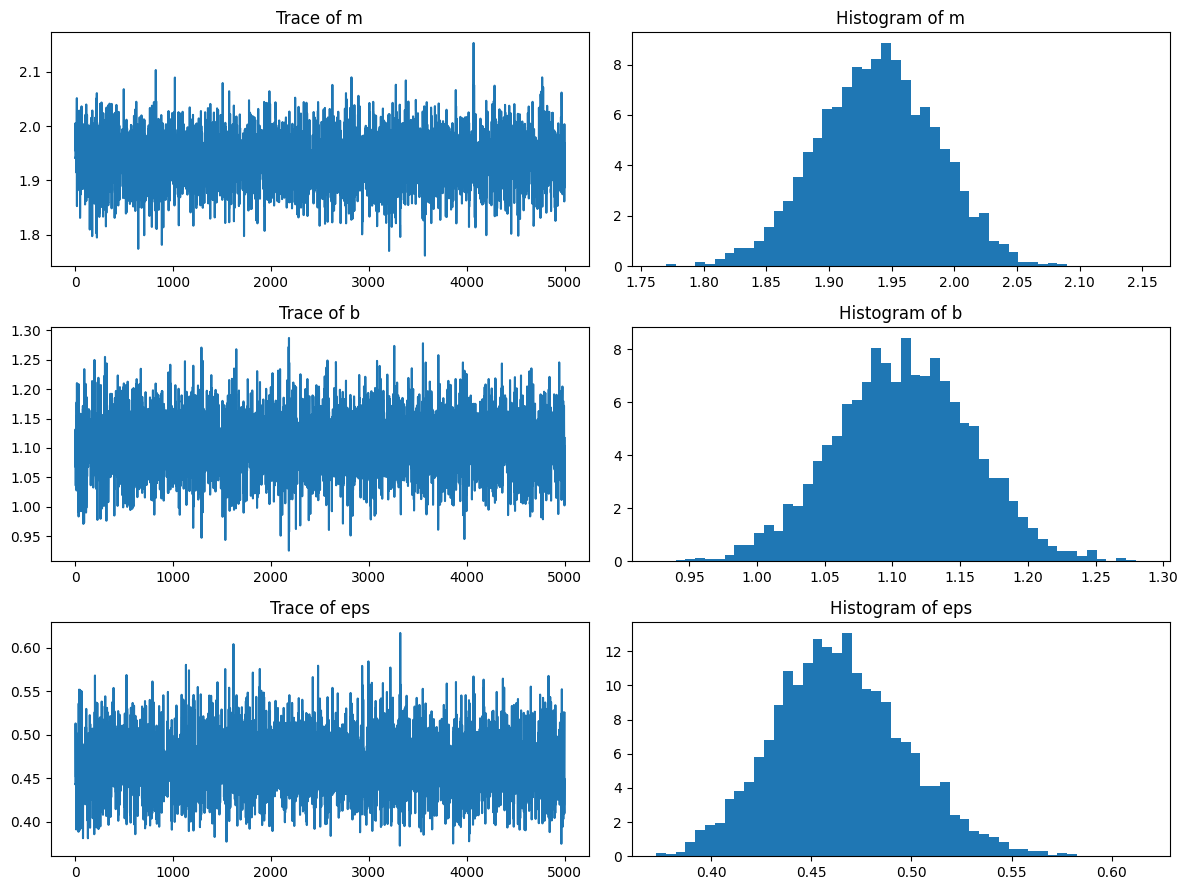

In [28]:
m_chains = np.concatenate([chain[0].numpy() for chain in chains])
b_chains = np.concatenate([chain[1].numpy() for chain in chains])
eps_chains = np.concatenate([chain[2].numpy() for chain in chains])

# Plot the trace and histogram of the posterior samples for each parameter
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))

axes[0, 0].plot(m_chains)
axes[0, 0].set_title('Trace of m')
axes[0, 1].hist(m_chains, bins=50, density=True)
axes[0, 1].set_title('Histogram of m')

axes[1, 0].plot(b_chains)
axes[1, 0].set_title('Trace of b')
axes[1, 1].hist(b_chains, bins=50, density=True)
axes[1, 1].set_title('Histogram of b')

axes[2, 0].plot(eps_chains)
axes[2, 0].set_title('Trace of eps')
axes[2, 1].hist(eps_chains, bins=50, density=True)
axes[2, 1].set_title('Histogram of eps')

plt.tight_layout()
#plt.show()

m_mean, m_lower, m_upper = np.mean(m_chains), np.percentile(m_chains, 2.5), np.percentile(m_chains, 97.5)
b_mean, b_lower, b_upper = np.mean(b_chains), np.percentile(b_chains, 2.5), np.percentile(b_chains, 97.5)
eps_mean, eps_lower, eps_upper = np.mean(eps_chains), np.percentile(eps_chains, 2.5), np.percentile(eps_chains, 97.5)

print(f"m: mean={m_mean:.3f}, 95% CI=({m_lower:.3f}, {m_upper:.3f})")
print(f"b: mean={b_mean:.3f}, 95% CI=({b_lower:.3f}, {b_upper:.3f})")
print(f"eps: mean={eps_mean:.3f}, 95% CI=({eps_lower:.3f}, {eps_upper:.3f})")